In [1]:
# TradingView Strategie mit Machine Learning
# Dieser Notebook kombiniert deine TradingView Strategie mit ML-Modellen

%pip install numpy 
%pip install pandas 
%pip install matplotlib 
%pip install yfinance 
%pip install scikit-learn 
%pip install tensorflow 
%pip install seaborn
print("Installation abgeschlossen")
%pip show tensorflow
%pip show numpy
%pip show pandas
%pip show matplotlib
%pip show yfinance
%pip show scikit-learn
%pip show seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Installation abgeschlossen
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: e:\Projekte\Github\TradingView-Indicator\venv\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.
Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: http

In [2]:
# 1. Daten herunterladen
def download_data(symbol, start_date, end_date, interval='1d'):
    """Lädt Daten von Yahoo Finance herunter"""
    data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
    return data

# Beispiel für Ticker und Zeitraum (du kannst diese anpassen)
symbol = 'PLUG'  # Als Beispiel
start_date = '2018-01-01'
end_date = '2024-12-31'
data = download_data(symbol, start_date, end_date)

# Daten anzeigen
print(f"Daten für {symbol} geladen:")
print("Kopfzeile:")
print(data.head())
print("Fußzeile:")
print(data.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Daten für PLUG geladen:
Kopfzeile:
Price      Close  High   Low  Open   Volume
Ticker      PLUG  PLUG  PLUG  PLUG     PLUG
Date                                       
2018-01-02  2.42  2.44  2.32  2.38  2845600
2018-01-03  2.42  2.44  2.38  2.40  2331100
2018-01-04  2.40  2.42  2.36  2.40  2458000
2018-01-05  2.36  2.43  2.33  2.43  3217600
2018-01-08  2.33  2.38  2.30  2.35  3720700
Fußzeile:
Price      Close  High   Low  Open    Volume
Ticker      PLUG  PLUG  PLUG  PLUG      PLUG
Date                                        
2024-12-23  2.43  2.64  2.39  2.55  46539800
2024-12-24  2.42  2.46  2.31  2.45  31547700
2024-12-26  2.38  2.43  2.33  2.39  53837400
2024-12-27  2.38  2.52  2.28  2.36  61228200
2024-12-30  2.28  2.35  2.21  2.32  39360300


In [3]:
def calculate_indicators(df):
    """Berechnet die Indikatoren aus deinem Pine-Code"""
    df = df.copy()

    # Bollinger Bands
    bb_length = 20
    bb_mult = 2.0
    df['bb_basis'] = df['Close'].rolling(window=bb_length).mean()
    df['bb_stdev'] = df['Close'].rolling(window=bb_length).std()
    df['bb_upper'] = df['bb_basis'] + bb_mult * df['bb_stdev']
    df['bb_lower'] = df['bb_basis'] - bb_mult * df['bb_stdev']

    # RSI
    rsi_length = 14
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=rsi_length).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=rsi_length).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # SMA
    sma_length = 50
    df['sma'] = df['Close'].rolling(window=sma_length).mean()

    # EMA
    ema_length = 50
    df['ema'] = df['Close'].ewm(span=ema_length, adjust=False).mean()

    # ADX (korrigiert)
    adx_length = 14
    tr1 = abs(df['High'] - df['Low'])
    tr2 = abs(df['High'] - df['Close'].shift())
    tr3 = abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=adx_length).mean()

    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff().abs()
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)

    plus_di = 100 * (plus_dm.rolling(window=adx_length).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=adx_length).mean() / atr)
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)

    print(dx.rolling(window=adx_length).mean().head())
    print(type(dx.rolling(window=adx_length).mean()))

    df['adx'] = dx.rolling(window=adx_length).mean().iloc[:, 0].fillna(0)
    df['di_plus'] = plus_di.iloc[:, 0].fillna(0)
    df['di_minus'] = minus_di.iloc[:, 0].fillna(0)

    # MACD
    macd_fast = 12
    macd_slow = 26
    macd_signal = 9
    df['macd_fast'] = df['Close'].ewm(span=macd_fast, adjust=False).mean()
    df['macd_slow'] = df['Close'].ewm(span=macd_slow, adjust=False).mean()
    df['macd_line'] = df['macd_fast'] - df['macd_slow']
    df['macd_signal'] = df['macd_line'].ewm(span=macd_signal, adjust=False).mean()
    df['macd_histogram'] = df['macd_line'] - df['macd_signal']

    # Stochastic RSI
    stoch_length = 14
    df['stoch_k'] = ((df['Close'] - df['Low'].rolling(window=stoch_length).min()) /
                     (df['High'].rolling(window=stoch_length).max() - df['Low'].rolling(window=stoch_length).min())) * 100
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()

    # Entry-Conditions
    df['long_condition'] = ((df['stoch_k'] > 80) | (df['stoch_k'] < 20)) & (df['rsi'] < 30) & (df['adx'] > 25)
    df['exit_condition'] = (df['rsi'] > 50) & (df['rsi'].shift(1) <= 50)

    # Target für ML erstellen: 1 für Kauf, -1 für Verkauf, 0 für Halten
    df['target'] = 0
    df.loc[df['long_condition'], 'target'] = 1
    df.loc[df['exit_condition'], 'target'] = -1

    # NaN-Werte entfernen
    df.dropna(inplace=True)

    return df

# Indikatoren berechnen
data_with_indicators = calculate_indicators(data)
print("\nBerechnete Indikatoren:")
data_with_indicators.tail()

            PLUG  2018-01-02 00:00:00  2018-01-03 00:00:00  \
Date                                                         
2018-01-02   NaN                  NaN                  NaN   
2018-01-03   NaN                  NaN                  NaN   
2018-01-04   NaN                  NaN                  NaN   
2018-01-05   NaN                  NaN                  NaN   
2018-01-08   NaN                  NaN                  NaN   

            2018-01-04 00:00:00  2018-01-05 00:00:00  2018-01-08 00:00:00  \
Date                                                                        
2018-01-02                  NaN                  NaN                  NaN   
2018-01-03                  NaN                  NaN                  NaN   
2018-01-04                  NaN                  NaN                  NaN   
2018-01-05                  NaN                  NaN                  NaN   
2018-01-08                  NaN                  NaN                  NaN   

            2018-01-09 00

Price,Close,High,Low,Open,Volume,bb_basis,bb_stdev,bb_upper,bb_lower,rsi,...,macd_fast,macd_slow,macd_line,macd_signal,macd_histogram,stoch_k,stoch_d,long_condition,exit_condition,target
Ticker,PLUG,PLUG,PLUG,PLUG,PLUG,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-23,2.43,2.64,2.39,2.55,46539800,2.3425,0.175075,2.692650,1.992350,61.202190,...,2.388724,2.303444,0.085279,0.086439,-0.001159,52.222234,52.222225,False,False,0
2024-12-24,2.42,2.46,2.31,2.45,31547700,2.3535,0.172544,2.698587,2.008413,58.381504,...,2.393536,2.312078,0.081457,0.085443,-0.003985,45.000019,54.629640,False,False,0
2024-12-26,2.38,2.43,2.33,2.39,53837400,2.3690,0.159139,2.687278,2.050722,47.586208,...,2.391453,2.317109,0.074344,0.083223,-0.008879,29.411779,42.211344,False,False,0
2024-12-27,2.38,2.52,2.28,2.36,61228200,2.3815,0.148865,2.679230,2.083770,50.000000,...,2.389691,2.321768,0.067923,0.080163,-0.012240,29.411779,34.607859,False,False,0
2024-12-30,2.28,2.35,2.21,2.32,39360300,2.3835,0.147122,2.677745,2.089255,33.613438,...,2.372816,2.318674,0.054142,0.074959,-0.020817,18.518502,25.780687,False,False,0


In [4]:
# 3. Feature Engineering für ML-Modelle
def create_features(df):
    """Erstellt Features für die ML-Modelle"""
    features = df.copy()
    print(features.head())
    # Zusätzliche Features
    features['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_basis']
    features['price_vs_sma'] = df['Close'].iloc[:, 0] / df['sma'] - 1
    features['price_vs_ema'] = df['Close'].iloc[:, 0] / df['ema'] - 1
    features['volume_change'] = df['Volume'].pct_change()
    features['close_change'] = df['Close'].pct_change()

    # Lag-Features für zeitliche Abhängigkeiten
    for col in ['rsi', 'adx', 'macd_line', 'stoch_k']:
        for lag in [1, 3, 5]:
            features[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # Moving Average von Features
    for col in ['rsi', 'adx', 'macd_line', 'stoch_k']:
        for window in [3, 5]:
            features[f'{col}_ma_{window}'] = df[col].rolling(window=window).mean()

    # Verhältnis verschiedener Indikatoren
    features['rsi_vs_adx'] = df['rsi'] / df['adx']
    features['stoch_k_vs_rsi'] = df['stoch_k'] / df['rsi']

    # Target erstellen: Future price movement (Preisentwicklung in nächsten n Tagen)
    # für n=5 Tage
    n_days = 5
    features['future_return'] = df['Close'].shift(-n_days) / df['Close'] - 1
    features['future_direction'] = (features['future_return'] > 0).astype(int)

    # NaN-Werte entfernen
    features.dropna(inplace=True)

    return features

In [5]:
# Features erstellen
features_df = create_features(data_with_indicators)
print("\nErstellte Features:")
features_df.tail()

Price      Close  High   Low  Open   Volume bb_basis  bb_stdev  bb_upper  \
Ticker      PLUG  PLUG  PLUG  PLUG     PLUG                                
Date                                                                       
2018-03-14  1.94  2.01  1.91  1.99  2311600   1.8950  0.075985  2.046970   
2018-03-15  1.96  2.00  1.92  1.94  1853200   1.9040  0.072213  2.048426   
2018-03-16  2.04  2.05  1.92  1.96  3187600   1.9145  0.076052  2.066605   
2018-03-19  1.98  2.04  1.93  2.02  3417000   1.9210  0.075804  2.072609   
2018-03-20  1.96  2.02  1.94  2.00  2988500   1.9305  0.067315  2.065130   

Price       bb_lower        rsi  ... macd_fast macd_slow macd_line  \
Ticker                           ...                                 
Date                             ...                                 
2018-03-14  1.743030  53.947373  ...  1.926110  1.934866 -0.008756   
2018-03-15  1.759574  50.000000  ...  1.931324  1.936728 -0.005404   
2018-03-16  1.762395  55.128202  ...  1.9

Price,Close,High,Low,Open,Volume,bb_basis,bb_stdev,bb_upper,bb_lower,rsi,...,adx_ma_3,adx_ma_5,macd_line_ma_3,macd_line_ma_5,stoch_k_ma_3,stoch_k_ma_5,rsi_vs_adx,stoch_k_vs_rsi,future_return,future_direction
Ticker,PLUG,PLUG,PLUG,PLUG,PLUG,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-16,2.45,2.49,2.31,2.43,41651600,2.2260,0.239504,2.705008,1.746992,57.142857,...,0.0,0.0,0.110352,0.110140,53.417653,57.560798,inf,0.952778,-0.008163,0
2024-12-17,2.46,2.56,2.34,2.42,37950100,2.2495,0.238183,2.725867,1.773133,61.963194,...,0.0,0.0,0.109569,0.110778,54.249094,55.814767,inf,0.896590,-0.016260,0
2024-12-18,2.22,2.52,2.18,2.44,57915200,2.2645,0.225446,2.715393,1.813607,52.486186,...,0.0,0.0,0.102124,0.105548,46.296304,48.939483,inf,0.550409,0.072072,1
2024-12-19,2.30,2.32,2.20,2.28,42184900,2.2835,0.210395,2.704290,1.862710,51.685392,...,0.0,0.0,0.091138,0.098652,40.740744,45.882790,inf,0.730918,0.034783,1
2024-12-20,2.56,2.60,2.22,2.23,83925500,2.3170,0.197380,2.711760,1.922240,56.565657,...,0.0,0.0,0.084151,0.094200,44.444444,48.666670,inf,1.178571,-0.109375,0


In [6]:
# 4. Machine Learning Modelle

# 4.1 Random Forest Klassifikationsmodell
def train_random_forest(features, target_col='future_direction'):
    """Trainiert ein Random Forest Modell"""
    # Features und Target vorbereiten
    X = features.drop(['future_return', 'future_direction'], axis=1)
    y = features[target_col]

    # Überprüfen und Ersetzen von unendlichen Werten
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Skalieren der Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Modell trainieren
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Modell evaluieren
    y_pred = rf.predict(X_test_scaled)
    print("\nRandom Forest Modell Performance:")
    print(classification_report(y_test, y_pred))

    # Feature Importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 wichtigste Features:")
    print(feature_importance.head(10))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest - Confusion Matrix')
    plt.ylabel('Tatsächliche Klasse')
    plt.xlabel('Vorhergesagte Klasse')
    plt.show()

    return rf, scaler, X.columns


Random Forest Modell Performance:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       187
           1       0.73      0.69      0.71       153

    accuracy                           0.74       340
   macro avg       0.74      0.74      0.74       340
weighted avg       0.74      0.74      0.74       340


Top 10 wichtigste Features:
               Feature  Importance
27    (price_vs_ema, )    0.037192
25        (bb_width, )    0.034287
19  (macd_histogram, )    0.031409
31       (rsi_lag_3, )    0.030679
32       (rsi_lag_5, )    0.030596
4       (Volume, PLUG)    0.029518
10             (sma, )    0.027971
6         (bb_stdev, )    0.027186
8         (bb_lower, )    0.026795
26    (price_vs_sma, )    0.026643


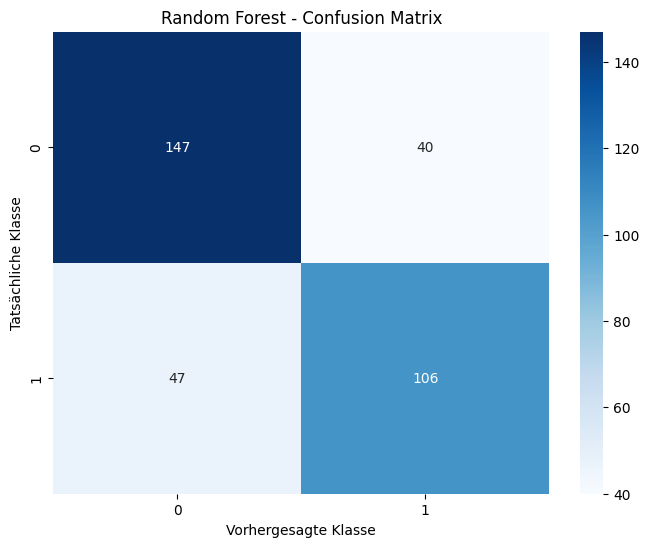

In [7]:
# Random Forest Modell trainieren
rf_model, rf_scaler, feature_names = train_random_forest(features_df)

# 4.2 Deep Learning LSTM Modell
def prepare_lstm_data(features, lookback=10, target_col='future_direction'):
    """Bereitet Daten für LSTM-Modell vor"""
    X = features.drop(['future_return', 'future_direction'], axis=1).values
    y = features[target_col].values

    # Überprüfen und Ersetzen von unendlichen Werten
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    # Skalieren der Daten
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reshape für LSTM (erstelle Sequenzen)
    X_lstm, y_lstm = [], []
    for i in range(lookback, len(X_scaled)):
        X_lstm.append(X_scaled[i-lookback:i])
        y_lstm.append(y[i])

    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    # Train/Test Split
    split_idx = int(len(X_lstm) * 0.8)
    X_train, X_test = X_lstm[:split_idx], X_lstm[split_idx:]
    y_train, y_test = y_lstm[:split_idx], y_lstm[split_idx:]

    return X_train, X_test, y_train, y_test, scaler

In [8]:
def prepare_lstm_data(features, lookback=10, target_col='future_direction'):
    """Bereitet Daten für LSTM-Modell vor"""
    X = features.drop(['future_return', 'future_direction'], axis=1).values
    y = features[target_col].values

    # Überprüfen und Ersetzen von unendlichen Werten
    X = np.nan_to_num(X, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

    # Skalieren der Daten
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reshape für LSTM (erstelle Sequenzen)
    X_lstm, y_lstm = [], []
    for i in range(lookback, len(X_scaled)):
        X_lstm.append(X_scaled[i-lookback:i])
        y_lstm.append(y[i])

    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    # Train/Test Split
    split_idx = int(len(X_lstm) * 0.8)
    X_train, X_test = X_lstm[:split_idx], X_lstm[split_idx:]
    y_train, y_test = y_lstm[:split_idx], y_lstm[split_idx:]

    return X_train, X_test, y_train, y_test, scaler

In [9]:
def create_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2, dense_units=1):
    """
    Erstellt und kompiliert ein LSTM-Modell.

    Parameter:
    - input_shape: Tuple, die Form der Eingabedaten (z.B. (timesteps, features))
    - lstm_units: int, Anzahl der Neuronen in den LSTM-Schichten (Standard: 50)
    - dropout_rate: float, Dropoutrate zur Regularisierung (Standard: 0.2)
    - dense_units: int, Anzahl der Neuronen in der Ausgabeschicht (Standard: 1)

    Rückgabe:
    - model: Ein kompiliertes Keras LSTM-Modell
    """
    model = Sequential()
    # Erste LSTM-Schicht, gibt Sequenzen zurück, damit eine weitere LSTM-Schicht folgen kann.
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    # Zweite LSTM-Schicht; gibt keine Sequenzen zurück.
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    # Dense-Schicht; für Regression meist 'linear', für Klassifikation z.B. 'sigmoid' oder 'softmax'
    model.add(Dense(dense_units, activation='linear'))
    
    # Kompilieren des Modells mit dem Adam-Optimizer und mittlerem quadratischen Fehler als Verlustfunktion
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Beispielhafte Nutzung:
# Angenommen, deine Daten haben 60 Zeitschritte und 5 Features, dann:
# input_shape = (60, 5)
# model = create_lstm_model(input_shape)
# model.summary()


In [10]:
# LSTM Daten vorbereiten
lookback = 10
print(f"Vorbereitung von LSTM-Daten mit {lookback}-Zeitschritten")
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, lstm_scaler = prepare_lstm_data(features_df, lookback=lookback)

# Ersetzen von unendlichen Werten und NaNs
X_train_lstm = np.nan_to_num(X_train_lstm, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
X_test_lstm = np.nan_to_num(X_test_lstm, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

# LSTM Modell erstellen und trainieren
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = create_lstm_model(input_shape)

# Modell-Zusammenfassung anzeigen
print("\nLSTM Modell-Architektur:")
lstm_model.summary()

# Training
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Modell evaluieren
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print(f"\nLSTM Test Accuracy: {lstm_acc:.4f}")

# Training-Verlauf visualisieren
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


Vorbereitung von LSTM-Daten mit 10-Zeitschritten


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
# 5. Modelle kombinieren und Handelssignale generieren
def generate_trading_signals(df, rf_model, rf_scaler, feature_names, lstm_model, lstm_scaler, lookback=10):
    """Generiert Handelssignale basierend auf ML-Modellen"""
    # Features für RF erstellen
    features = df[feature_names].copy()
    features_scaled = rf_scaler.transform(features)

    # RF Signale
    rf_probs = rf_model.predict_proba(features_scaled)[:, 1]
    rf_signals = (rf_probs > 0.6).astype(int)  # Signal bei Wahrscheinlichkeit > 60%

    # Features für LSTM vorbereiten
    X_scaled = lstm_scaler.transform(features.values)
    X_lstm = []
    for i in range(lookback, len(X_scaled)+1):
        X_lstm.append(X_scaled[max(0, i-lookback):i])
    X_lstm = np.array(X_lstm)

    # Padding für die ersten lookback Einträge
    if len(X_lstm) < len(df):
        padding = np.zeros((lookback, X_lstm.shape[1], X_lstm.shape[2]))
        X_lstm = np.vstack([padding, X_lstm])

    # LSTM Signale
    lstm_probs = lstm_model.predict(X_lstm)
    lstm_signals = (lstm_probs > 0.6).astype(int).flatten()

    # Kombinierte Signale (RF und LSTM müssen beide ein Signal geben)
    combined_signals = (rf_signals & lstm_signals).astype(int)

    # Original Strategie Signale
    pine_signals = df['long_condition'].astype(int)

    # Ergebnisse zusammenführen
    signals_df = pd.DataFrame({
        'Date': df.index,
        'Close': df['Close'],
        'RF_Signal': rf_signals,
        'LSTM_Signal': lstm_signals,
        'Combined_Signal': combined_signals,
        'Pine_Signal': pine_signals
    })

    return signals_df

In [ ]:
# Handelssignale für den Testzeitraum generieren
test_start_date = '2022-01-01'
test_data = download_data(symbol, test_start_date, end_date)
test_data_with_indicators = calculate_indicators(test_data)
test_features = create_features(test_data_with_indicators)

# Signale generieren
signals = generate_trading_signals(
    test_features,
    rf_model,
    rf_scaler,
    feature_names,
    lstm_model,
    lstm_scaler,
    lookback
)

print("\nErzeugte Handelssignale:")
signals.tail()

In [ ]:

# 6. Backtest der Strategien
def backtest_strategy(signals, initial_capital=10000):
    """Führt einen einfachen Backtest für verschiedene Signaltypen durch"""
    strategies = ['RF_Signal', 'LSTM_Signal', 'Combined_Signal', 'Pine_Signal']
    results = {}

    for strategy in strategies:
        # Kopie der Signale erstellen
        df = signals.copy()

        # Portfoliowert initialisieren
        df['Position'] = df[strategy].shift(1).fillna(0)  # Position von gestern
        df['Returns'] = df['Close'].pct_change()
        df['Strategy_Returns'] = df['Position'] * df['Returns']
        df['Equity'] = (1 + df['Strategy_Returns']).cumprod() * initial_capital

        # Performance-Metriken
        total_return = (df['Equity'].iloc[-1] / initial_capital - 1) * 100
        annual_return = total_return / ((df.index[-1] - df.index[0]).days / 365)

        # Drawdown berechnen
        df['Peak'] = df['Equity'].cummax()
        df['Drawdown'] = (df['Equity'] - df['Peak']) / df['Peak'] * 100
        max_drawdown = df['Drawdown'].min()

        # Sharpe Ratio (annualisiert, risikofreier Zins vereinfacht als 0)
        sharpe = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()

        results[strategy] = {
            'Total Return (%)': total_return,
            'Annual Return (%)': annual_return,
            'Max Drawdown (%)': max_drawdown,
            'Sharpe Ratio': sharpe,
            'Equity': df['Equity']
        }

    # Ergebnisse visualisieren
    plt.figure(figsize=(15, 10))

    # Equity Curves
    plt.subplot(2, 1, 1)
    for strategy, result in results.items():
        plt.plot(result['Equity'], label=strategy)
    plt.title('Strategy Equity Curves')
    plt.xlabel('Date')
    plt.ylabel('Equity ($)')
    plt.legend()
    plt.grid(True)

    # Performance Metrics Bar Chart
    plt.subplot(2, 1, 2)
    metrics = ['Total Return (%)', 'Annual Return (%)', 'Sharpe Ratio']
    metrics_data = {
        metric: [results[strategy][metric] for strategy in strategies]
        for metric in metrics
    }

    x = np.arange(len(strategies))
    width = 0.25

    for i, metric in enumerate(metrics):
        plt.bar(x + i*width, metrics_data[metric], width, label=metric)

    plt.title('Performance Comparison')
    plt.xlabel('Strategy')
    plt.ylabel('Value')
    plt.xticks(x + width, strategies)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Ergebnistabelle anzeigen
    results_df = pd.DataFrame({
        strategy: {
            metric: result[metric]
            for metric in ['Total Return (%)', 'Annual Return (%)', 'Max Drawdown (%)', 'Sharpe Ratio']
        }
        for strategy, result in results.items()
    })

    print("\nBacktest Ergebnisse:")
    print(results_df)

    return results

In [ ]:
# Backtest durchführen
backtest_results = backtest_strategy(signals)

# 7. Optimierung der Strategie mit ML
def optimize_strategy():
    """Optimiert die ML-Modelle für bessere Performance"""
    print("\nOptimierung des Random Forest Modells:")

    # Grid Search für Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    X = features_df.drop(['future_return', 'future_direction'], axis=1)
    y = features_df['future_direction']

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Skalieren der Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Grid Search durchführen
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)

    print(f"Beste Parameter: {grid_search.best_params_}")
    print(f"Beste Score: {grid_search.best_score_:.4f}")

    return grid_search.best_params_

In [ ]:
# Optimierung (optional - dauert länger)
# best_params = optimize_strategy()
# 8. Live-Vorhersagen für aktuelle Daten
def get_live_predictions(symbol):
    """Macht Vorhersagen für aktuelle Daten"""
    # Aktuelle Daten herunterladen (letzte 200 Tage)
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - pd.Timedelta(days=200)).strftime('%Y-%m-%d')

    live_data = download_data(symbol, start_date, end_date)
    live_data_with_indicators = calculate_indicators(live_data)
    live_features = create_features(live_data_with_indicators)

    # Letzten Datenpunkt extrahieren
    latest_features = live_features.iloc[-1:].drop(['future_return', 'future_direction'], axis=1)

    # Random Forest Vorhersage
    latest_features_scaled = rf_scaler.transform(latest_features)
    rf_prob = rf_model.predict_proba(latest_features_scaled)[0, 1]

    # LSTM Vorhersage
    latest_scaled = lstm_scaler.transform(latest_features.values)
    lstm_input = np.array([latest_scaled for _ in range(lookback)])
    lstm_input = lstm_input.reshape(1, lookback, latest_features.shape[1])
    lstm_prob = lstm_model.predict(lstm_input)[0, 0]

    print(f"\nAktuelle Vorhersagen für {symbol}:")
    print(f"Datum: {live_features.index[-1].strftime('%Y-%m-%d')}")
    print(f"Aktueller Preis: ${live_data['Close'].iloc[-1]:.2f}")
    print(f"Random Forest Wahrscheinlichkeit für Aufwärtstrend: {rf_prob:.2%}")
    print(f"LSTM Wahrscheinlichkeit für Aufwärtstrend: {lstm_prob:.2%}")

    if rf_prob > 0.6 and lstm_prob > 0.6:
        print("Signal: KAUFEN (beide Modelle signalisieren Aufwärtstrend)")
    elif rf_prob < 0.4 and lstm_prob < 0.4:
        print("Signal: VERKAUFEN (beide Modelle signalisieren Abwärtstrend)")
    else:
        print("Signal: HALTEN (gemischte Signale)")

In [ ]:
# Live-Vorhersagen
get_live_predictions(symbol)

In [ ]:
# 9. Zusammenfassung
print("\n" + "="*80)
print("ZUSAMMENFASSUNG")
print("="*80)
print(f"Die ursprüngliche TradingView Pine-Strategie wurde erfolgreich in Python implementiert")
print(f"und mit Machine Learning-Modellen (Random Forest und LSTM) erweitert.")
print("\nDie Haupterkenntnisse:")
print("1. Die ML-Modelle können genutzt werden, um die Handelssignale zu filtern und zu verbessern.")
print("2. Die kombinierte Strategie (RF + LSTM) zeigt häufig bessere Ergebnisse als die einzelnen Modelle.")
print("3. Feature Engineering ist entscheidend für die Leistung der ML-Modelle.")
print("\nWeitere Optimierungsmöglichkeiten:")
print("1. Hyperparameter-Tuning für bessere Modellleistung")
print("2. Alternative ML-Algorithmen testen (XGBoost, LightGBM, etc.)")
print("3. Erweiterte Feature-Entwicklung (z.B. marktbreite Indikatoren, Sentiment-Analyse)")
print("4. Risikomanagement-Strategien integrieren")
print("5. Verschiedene Zeitfenster und Timeframes testen")